# Replication of Mackowiak and Wiederholt (2009)

This example replicates [Mackowiak and Wiederholt (2009)](https://www.aeaweb.org/articles?id=10.1257/aer.99.3.769) (henceforth MW) using the [DRIPs](https://github.com/afrouzi/DRIPs) package.

In [1]:
#[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/www.github.com/afrouzi/DRIPs.jl/binder?filepath=examples) to run and modify the following code (no software is needed on the local machine).

See [Afrouzi and Yang (2019)](http://www.afrouzi.com/dynamic_inattention.pdf) for background on the theory.

## Contents
* Setup
* Mapping the Problem to a DRIP
* Initialization
* Functions
    * Solving for the fixed point given $\omega$
    * Solving for the optimal $\omega$
* Figures
    * Benchmark Economy
    * Other values of real rigidity
    * Other values of information capacity
* Measuring Performance/Speed

## Setup

The problem in MW is
$$
\begin{aligned}
    &\min_{\{\hat{\Delta}_{i,t},\hat{z}_{i,t}\}} \left\{ E\left[(\Delta_t-\hat{\Delta}_{i,t})^2\right]+\underset{\equiv \xi}{\underbrace{\left(\frac{\hat{\pi}_{14}}{\hat{\pi}_{11}}\right)}}^2E\left[(z_{i,t}-\hat{z}_{i,t})^2\right]\right\}, \\
    s.t.\quad & \mathcal{I}(\{\Delta_t\};\{\hat{\Delta}_{i,t}\})+\mathcal{I}(\{z_{i,t}\};\{\hat{z}_{i,t}\})\leq \kappa, \\
    & \{\Delta_t,\hat{\Delta}_{i,t}\} \perp \{z_{i,t},\hat{z}_{i,t}\}
\end{aligned}
$$
where
$$
\begin{aligned}
    \Delta_t&\equiv p_t + \underset{\equiv 1-\alpha}{\underbrace{\left(\frac{|\hat{\pi}_{13}|}{|\hat{\pi}_{11}|}\right)}}(q_t-p_t) \\
    p_t &= \int_0^1 \hat{\Delta}_{i,t}di \\
    q_t &= \rho q_{t-1} + \nu_t, \nu_{q,t}\sim \mathcal{N}(0,\sigma_q^2) \\
    z_{i,t}&= \rho z_{i,t-1} + \nu_{z,t}, \nu_{z,t}\sim \mathcal{N}(0,\sigma_z^2)
\end{aligned}
$$

## Mapping the Problem to a DRIP

There are a few ways of translating the problem above to a D.R.I.P. structure; however, the most efficient way, due to the independence assumption, is to write it as the sum of two D.R.I.P.'s: one that solves the attention problem for the idiosyncratic shock, and one that solves the attention problem for the aggregate shock which also has endogenous feedback.

Moreover, since the problem above has a fixed capacity, instead of a fixed cost of attention ($\omega$) as in D.R.I.P. pacakge, we need to iterate over $\omega$'s to find the one that corresponds with $\kappa$.

## Initialization
Include the package::

In [2]:
using DRIPs;

Assign parameters:

In [3]:
ρ  = 0.95;
σq = 0.01;
σz = 11.8*σq;
κ  = 3;
ξ  = 1;
α  = 1 - 0.15;

Primitives of Drip:

In [4]:
using LinearAlgebra;
L  = 21; # length of trunction
A  = [zeros(1,L);[Matrix(I,L-1,L-1);zeros(1,L-1)]']; # MW truncate the state space with linear irfs of length 20
Qq = zeros(L,1); Qq[1]=σq;
Qz = zeros(L,1); Qz[1]=σz;
H  = zeros(L,1); H[1:21] = Array(1:-1/20:0);

## Functions
We start with a function that solves the aggregate problem with feedback for a given $\omega$.
### Solving for the fixed point given $\omega$

In [5]:
function agg_drip(ω,A,Qq,        #primitives of drip except for H because H is endogenous
                  α,             #strategic complementarity
                  H;             #state space rep. of q
                  β     = 1,     #optional: discount factor, MW's parameterization implies β = 1
                  H0    = H,     #optional: initial guess for HΔ (H is the true solution when α=0)
                  maxit = 10000, #optional: max number of iterations for GE code
                  tol   = 1e-4,  #optional: tolerance for iterations
                  w     = 1)     #optional: update weight for RI
    errmin= 1;
    err   = 1;
    iter  = 0;
    L     = length(H);
    while (err > tol) & (iter < maxit)
            if iter == 0
                global agg  = solve_drip(ω,β,A,Qq,H0;w = w);
            else
                global agg  = solve_drip(ω,β,A,Qq,H0;Ω0 = agg.Ω , Σ0 = agg.Σ_1,w = w);
            end

            XFUN(jj) = ((I-agg.K*agg.Y')*agg.A)^jj * (agg.K*agg.Y') * (agg.A')^jj
            X = DRIPs.infinitesum(XFUN; maxit=200, start = 0);  #E[x⃗]=X×x⃗

            XpFUN(jj) = α^jj * X^(jj)
            Xp = DRIPs.infinitesum(XpFUN; maxit=200, start = 0);

            H1 = (1-α)*Xp'*H;

            err= 0.5*norm(H1-H0,2)/norm(H0)+0.5*err;
            if DRIPs.capacity(agg) < 1e-2 # perturb the initial guess if solution is the zero capacity one
                H0 = H0+rand(L).*(H-H0);
            else # store the solution if it has positive capacity
                H0 = H1;
                if err < errmin
                    global aggmin = agg;
                    errmin = err;
                end
            end
            iter += 1;
    end
    return(aggmin, errmin)
end;

Now we need a function that iterates over $\omega$'s to find the one that corresponds to a given capacity for the MW problem.
### Solving for the optimal $\omega$

In [6]:
using Printf;
function MW(κ,α,A,Qq,Qz,Hq,Hz; #primitives of MW problem
            ω     = σq^2,      #optional: initial guess for ω
            tol   = 1e-3,      #optional: tolerance for κ
            maxit = 10000)     #optional: max iterations
    ωs    = [ω; 2*ω];
    caps  = [];
    iter  = 0;
    err   = 1;
    it    = 0;
    while (err > tol) & (iter < maxit)
        agg, errtemp = agg_drip(ω,A,Qq,α,H; H0 = rand(L),maxit=25,w=0.95);
        idi = solve_drip(ω,1,A,Qz,H,w = 0.9) ;
        cap = DRIPs.capacity(agg, unit = "bit") + DRIPs.capacity(idi, unit = "bit");
        x = ω/σq^2;
        @printf("ω = %.2fσq² for κ = %.2f \n",x,cap)
        push!(caps,cap);
        if it == 0
            ω = ωs[end];
        else
            slope = (caps[end]-caps[end-1])/(ωs[end]-ωs[end-1]);
            ω     = ω + (κ-caps[end])/slope;
            push!(ωs,ω);
        end
        err = abs(caps[end] - κ)/κ;
        it  += 1;
    end
    return(ω);
end;

## Figures
Start with the benchmark calibration:
### Benchmark Economy

In [7]:
ω = MW(3,α,A,Qq,Qz,H,H);

agg, err  = agg_drip(ω,A,Qq,α,H; H0 = rand(L), maxit = 500, w = 0.95);
idi       = solve_drip(ω,1,A,Qz,H,w = 0.9);

@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",DRIPs.capacity(agg),DRIPs.capacity(idi));

ω = 1.00σq² for κ = 3.67 
ω = 2.00σq² for κ = 3.10 
ω = 2.18σq² for κ = 3.02 
ω = 2.23σq² for κ = 3.00 
ω = 2.23σq² for κ = 3.00 
Agg. Capacity = 0.12 bits, Idio. Capacity = 2.90 bits

Plot IRFs

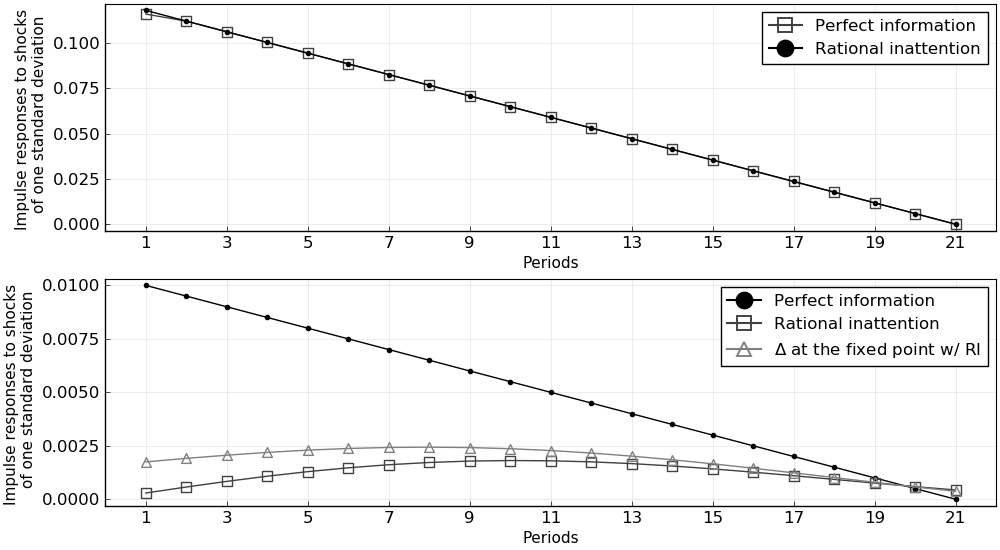

In [8]:
iirfs  = dripirfs(idi, T = L)
airfs  = dripirfs(agg, T = L)

using Plots, LaTeXStrings; pyplot();
p1 = plot([iirfs.a[1,1,:],σz*H],
     label             = ["Perfect information" "Rational inattention"],
     marker            = [:square :circle],
     color             = [:gray25 :black],
     markercolor       = [false :black],
     markerstrokecolor = [:gray25 :black],
     markersize        = [7 3],
     xlabel            = "Periods",
     ylabel            = "Impulse responses to shocks \n of one standard deviation");
p2 = plot([σq*H,airfs.a[1,1,1:end],σq*agg.H],
     label             = ["Perfect information" "Rational inattention" L"$\Delta$ at the fixed point w/ RI"],
     marker            = [:circle :square :utriangle],
     color             = [:black :gray25 :gray50],
     markercolor       = [:black false false] ,
     markerstrokecolor = [:black :gray25 :gray50],
     markersize        = [3 7 7],
     xlabel            = "Periods",
     ylabel            = "Impulse responses to shocks \n of one standard deviation")

plot(p1,p2,
    layout     = (2,1),
    xlim       = (0,L+1),
    lw         = 1,
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (1000,550),
    xticks     = 1:2:21,
    framestyle = :box)

### Other values of real rigidity ($\alpha$)

For $\alpha = 0.7$:

In [9]:
ω_α7 = MW(3,0.7,A,Qq,Qz,H,H);

agg_α7, err = agg_drip(ω_α7,A,Qq,0.7,H; H0 = rand(L), maxit = 100, w = 0.95);
idi_α7      = solve_drip(ω_α7,1,A,Qz,H,w = 0.9);

@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",
        DRIPs.capacity(agg_α7),DRIPs.capacity(idi_α7));

ω = 1.00σq² for κ = 3.83 
ω = 2.00σq² for κ = 3.20 
ω = 2.31σq² for κ = 3.06 
ω = 2.46σq² for κ = 3.01 
ω = 2.48σq² for κ = 3.00 
Agg. Capacity = 0.17 bits, Idio. Capacity = 2.83 bits

For $\alpha = 0$:

In [10]:
ω_α0 = MW(3,0,A,Qq,Qz,H,H);

agg_α0, err = agg_drip(ω_α0,A,Qq,0,H; H0 = rand(L), maxit = 100, w = 0.95);
idi_α0      = solve_drip(ω_α0,1,A,Qz,H,w = 0.9);

@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",
        DRIPs.capacity(agg_α0),DRIPs.capacity(idi_α0));

ω = 1.00σq² for κ = 4.06 
ω = 2.00σq² for κ = 3.39 
ω = 2.59σq² for κ = 3.16 
ω = 2.99σq² for κ = 3.03 
ω = 3.08σq² for κ = 3.00 
Agg. Capacity = 0.32 bits, Idio. Capacity = 2.68 bits

Plot IRFs:

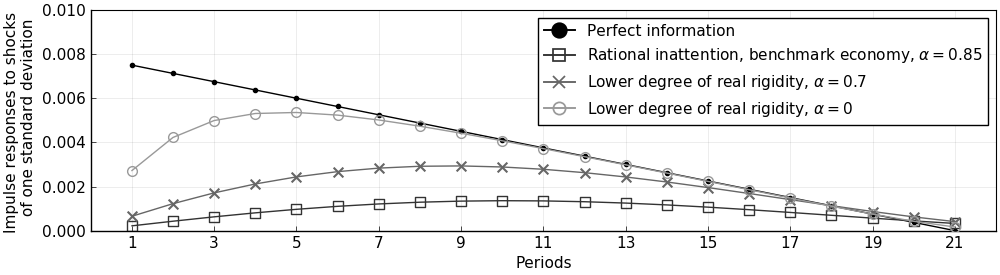

In [11]:
airfs_α7  = dripirfs(agg_α7, T = L);
airfs_α0  = dripirfs(agg_α0, T = L);

plot(1:L,0.75*[σq*H,airfs.a[1,1,:],airfs_α7.a[1,1,:],airfs_α0.a[1,1,:]],
    label             = ["Perfect information" L"Rational inattention, benchmark economy, $\alpha = 0.85$" L"Lower degree of real rigidity, $\alpha = 0.7$" L"Lower degree of real rigidity, $\alpha = 0$"],
    marker            = [:circle :square :x :circle],
    color             = [:black :gray20 :gray40 :gray60],
    markercolor       = [:black false :gray40 false],
    markerstrokecolor = [:black :gray20 :gray40 :gray60],
    markersize        = [3 7 7 7],
    xlim              = (0,L+1),
    lw                = 1,
    xticks            = 1:2:21,
    legend            = :topright,
    legendfont        = font(11),
    tickfont          = font(11),
    size              = (1000,275),
    ylim              = (0,σq),
    framestyle        = :box,
    xlabel            = "Periods",
    ylabel            = "Impulse responses to shocks \n of one standard deviation")

### Other values of information capacity ($\kappa$)
For $\kappa=4$:

In [12]:
ω_κ4 = MW(4,α,A,Qq,Qz,H,H);

agg_κ4, err = agg_drip(ω_κ4,A,Qq,α,H; H0 = rand(L), maxit = 500, w = 0.95)
idi_κ4      = solve_drip(ω_κ4,1,A,Qz,H,w = 0.9)

@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",
        DRIPs.capacity(agg_κ4),DRIPs.capacity(idi_κ4));

ω = 1.00σq² for κ = 3.66 
ω = 2.00σq² for κ = 3.06 
ω = 0.45σq² for κ = 4.44 
ω = 0.94σq² for κ = 3.73 
ω = 0.75σq² for κ = 3.94 
ω = 0.70σq² for κ = 4.01 
ω = 0.71σq² for κ = 4.00 
Agg. Capacity = 0.34 bits, Idio. Capacity = 3.66 bits

For $\kappa=5$:

In [13]:
ω_κ5 = MW(5,α,A,Qq,Qz,H,H; ω = 0.1*σq^2);

agg_κ5, err = agg_drip(ω_κ5,A,Qq,α,H; H0 = rand(L), maxit = 500, w = 0.95)
idi_κ5      = solve_drip(ω_κ5,1,A,Qz,H,w = 0.9)

@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",
        DRIPs.capacity(agg_κ5),DRIPs.capacity(idi_κ5));

ω = 0.10σq² for κ = 6.14 
ω = 0.20σq² for κ = 5.29 
ω = 0.23σq² for κ = 5.12 
ω = 0.26σq² for κ = 5.02 
ω = 0.26σq² for κ = 5.00 
Agg. Capacity = 0.70 bits, Idio. Capacity = 4.30 bits

Plot IRFs:

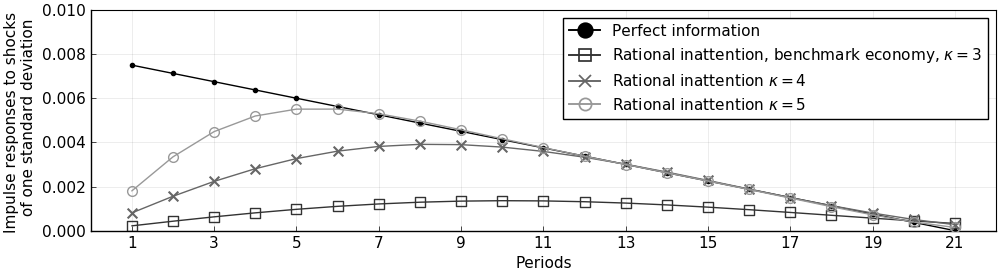

In [14]:
airfs_κ4  = dripirfs(agg_κ4, T = L);
airfs_κ5  = dripirfs(agg_κ5, T = L);

plot(1:L,0.75*[σq*H,airfs.a[1,1,:],airfs_κ4.a[1,1,:],airfs_κ5.a[1,1,:]],
    label             = ["Perfect information" L"Rational inattention, benchmark economy, $\kappa = 3$" L"Rational inattention $\kappa = 4$" L"Rational inattention $\kappa = 5$"],
    marker            = [:circle :square :x :circle],
    color             = [:black :gray20 :gray40 :gray60],
    markercolor       = [:black false :gray40 false],
    markerstrokecolor = [:black :gray20 :gray40 :gray60],
    markersize        = [3 7 7 7],
    xlim              = (0,L+1),
    lw                = 1,
    xticks            = 1:2:21,
    legend            = :topright,
    legendfont        = font(11),
    tickfont          = font(11),
    size              = (1000,275),
    ylim              = (0,σq),
    framestyle        = :box,
    xlabel            = "Periods",
    ylabel            = "Impulse responses to shocks \n of one standard deviation")

## Measure Performance/Speed
### Performance of the code for aggregate problem with feedback

For random values of $\omega$ and benchmark values of other parameters:

In [15]:
using BenchmarkTools;
@benchmark agg_drip(ω,A,Qq,α,H; H0 = rand(L), maxit = 100, w = 0.95) setup = (ω = σq^2*5*rand())

BenchmarkTools.Trial: 
  memory estimate:  111.36 MiB
  allocs estimate:  44699
  --------------
  minimum time:     143.491 ms (8.04% GC)
  median time:      732.248 ms (6.78% GC)
  mean time:        558.290 ms (7.32% GC)
  maximum time:     887.991 ms (7.02% GC)
  --------------
  samples:          10
  evals/sample:     1

For $\alpha=0.7$ and random values of $\omega$:

In [16]:
@benchmark agg_drip(ω_α7,A,Qq,0.7,H; H0 = rand(L), maxit = 100, w = 0.95) setup = (ω = σq^2*5*rand())

BenchmarkTools.Trial: 
  memory estimate:  60.12 MiB
  allocs estimate:  25800
  --------------
  minimum time:     79.731 ms (5.99% GC)
  median time:      123.487 ms (10.57% GC)
  mean time:        122.558 ms (10.24% GC)
  maximum time:     198.352 ms (10.81% GC)
  --------------
  samples:          41
  evals/sample:     1

### Performance of the code for idiosyncratic problem

In [17]:
@benchmark solve_drip(ω,1,A,Qz,H,w = 0.9) setup = (ω = σq^2*5*rand())

BenchmarkTools.Trial: 
  memory estimate:  12.94 MiB
  allocs estimate:  6135
  --------------
  minimum time:     27.541 ms (0.00% GC)
  median time:      29.397 ms (0.00% GC)
  mean time:        30.885 ms (3.95% GC)
  maximum time:     40.456 ms (14.82% GC)
  --------------
  samples:          162
  evals/sample:     1

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*